# A/B Testing — A Complete Example

This notebook walks through a full A/B testing workflow:

1. **Problem Setup** — Define hypothesis and metrics
2. **Sample Size Calculation** — Power analysis
3. **Data Simulation** — Generate realistic experiment data
4. **Exploratory Analysis** — Visualize the groups
5. **Statistical Testing** — Z-test for proportions, Chi-squared test, confidence intervals
6. **Bayesian Approach** — Beta-Binomial model as an alternative
7. **Interpretation** — How to make a decision

## 1. Problem Setup

**Scenario:** An e-commerce company wants to test whether a new checkout page design (Variant B) leads to a higher conversion rate than the current design (Variant A).

- **Null Hypothesis ($H_0$):** $p_B = p_A$ — The conversion rates are the same.
- **Alternative Hypothesis ($H_1$):** $p_B \neq p_A$ — The conversion rates differ (two-sided test).
- **Primary Metric:** Conversion rate (proportion of visitors who complete a purchase).
- **Significance Level:** $\alpha = 0.05$
- **Desired Power:** $1 - \beta = 0.80$

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import NormalIndPower
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted")
np.random.seed(42)

print("All libraries loaded ✓")

All libraries loaded ✓


## 2. Sample Size Calculation (Power Analysis)

Before running the experiment, we need to determine how many visitors per group are required to detect a meaningful difference.

We use a **minimum detectable effect (MDE)** — the smallest improvement we care about. If the baseline conversion rate is 10%, we want to detect at least a 2 percentage-point lift (to 12%).

In [2]:
# Parameters
baseline_rate = 0.10  # Current conversion rate (Control / Group A)
new_rate = 0.12       # Expected conversion rate (Variant B)
alpha = 0.05          # Significance level
power = 0.80          # Desired statistical power

# Effect size (Cohen's h for proportions)
effect_size = 2 * np.arcsin(np.sqrt(new_rate)) - 2 * np.arcsin(np.sqrt(baseline_rate))
print(f"Cohen's h effect size: {effect_size:.4f}")

# Required sample size per group
analysis = NormalIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative="two-sided")
sample_size = int(np.ceil(sample_size))

print(f"Required sample size per group: {sample_size:,}")
print(f"Total participants needed: {2 * sample_size:,}")

Cohen's h effect size: 0.0640
Required sample size per group: 3,835
Total participants needed: 7,670


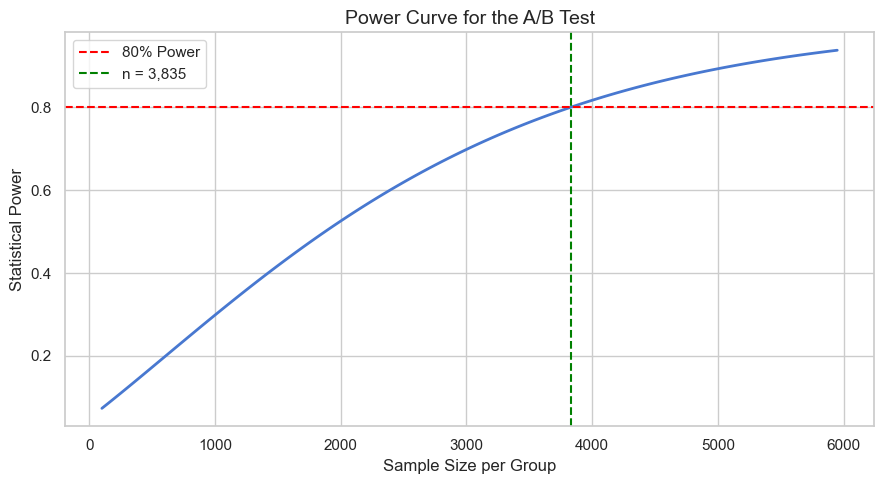

In [3]:
# Visualize power curve — how power changes with sample size
sample_sizes = np.arange(100, 6000, 50)
powers = [analysis.power(effect_size=effect_size, nobs1=n, alpha=alpha, alternative="two-sided") for n in sample_sizes]

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(sample_sizes, powers, linewidth=2)
ax.axhline(y=0.80, color="red", linestyle="--", label="80% Power")
ax.axvline(x=sample_size, color="green", linestyle="--", label=f"n = {sample_size:,}")
ax.set_xlabel("Sample Size per Group", fontsize=12)
ax.set_ylabel("Statistical Power", fontsize=12)
ax.set_title("Power Curve for the A/B Test", fontsize=14)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

## 3. Simulate Experiment Data

Now we simulate the experiment as if it has already been run. Each visitor is randomly assigned to Group A (control) or Group B (variant), and we observe whether they converted.

In [4]:
# Simulate data
n_A = sample_size
n_B = sample_size

# True underlying conversion rates
true_rate_A = 0.10
true_rate_B = 0.12

conversions_A = np.random.binomial(1, true_rate_A, n_A)
conversions_B = np.random.binomial(1, true_rate_B, n_B)

df = pd.DataFrame({
    "group": ["A"] * n_A + ["B"] * n_B,
    "converted": np.concatenate([conversions_A, conversions_B])
})

print(f"Dataset shape: {df.shape}")
df.head(10)

Dataset shape: (7670, 2)


,group,converted
0,A,0
1,A,1
2,A,0
3,A,0
4,A,0
5,A,0
6,A,0
7,A,0
8,A,0
9,A,0


In [5]:
# Summary statistics
summary = df.groupby("group")["converted"].agg(["count", "sum", "mean"])
summary.columns = ["Visitors", "Conversions", "Conversion Rate"]
summary["Conversion Rate"] = summary["Conversion Rate"].map("{:.4%}".format)
print(summary.to_string())

       Visitors  Conversions Conversion Rate
group                                       
A          3835          368         9.5958%
B          3835          450        11.7340%


## 4. Exploratory Data Analysis

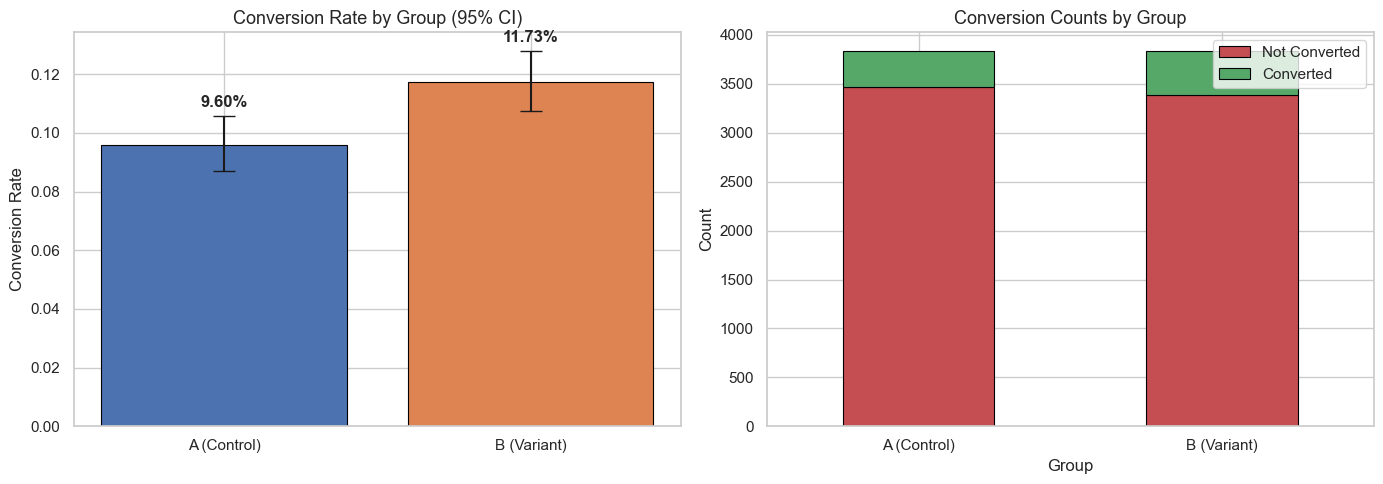

In [6]:
# Conversion rates with confidence intervals (for visualization)
rates = df.groupby("group")["converted"].mean()
counts = df.groupby("group")["converted"].sum()
nobs = df.groupby("group")["converted"].count()

# Wilson confidence intervals
ci_low_A, ci_high_A = proportion_confint(counts["A"], nobs["A"], alpha=0.05, method="wilson")
ci_low_B, ci_high_B = proportion_confint(counts["B"], nobs["B"], alpha=0.05, method="wilson")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Bar chart with error bars ---
groups = ["A (Control)", "B (Variant)"]
rate_vals = [rates["A"], rates["B"]]
ci_low = [rates["A"] - ci_low_A, rates["B"] - ci_low_B]
ci_high = [ci_high_A - rates["A"], ci_high_B - rates["B"]]
colors = ["#4C72B0", "#DD8452"]

axes[0].bar(groups, rate_vals, yerr=[ci_low, ci_high], capsize=8, color=colors, edgecolor="black", linewidth=0.8)
axes[0].set_ylabel("Conversion Rate", fontsize=12)
axes[0].set_title("Conversion Rate by Group (95% CI)", fontsize=13)
for i, v in enumerate(rate_vals):
    axes[0].text(i, v + ci_high[i] + 0.003, f"{v:.2%}", ha="center", fontsize=12, fontweight="bold")

# --- Distribution of conversions (counts) ---
conv_counts = df.groupby(["group", "converted"]).size().unstack(fill_value=0)
conv_counts.columns = ["Not Converted", "Converted"]
conv_counts.plot(kind="bar", stacked=True, ax=axes[1], color=["#C44E52", "#55A868"], edgecolor="black", linewidth=0.8)
axes[1].set_xlabel("Group", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].set_title("Conversion Counts by Group", fontsize=13)
axes[1].set_xticklabels(["A (Control)", "B (Variant)"], rotation=0)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

## 5. Statistical Testing

### 5a. Two-Proportion Z-Test

The standard frequentist test for comparing two proportions. Under $H_0$, the test statistic

$$Z = \frac{\hat{p}_B - \hat{p}_A}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_A}+\frac{1}{n_B}\right)}}$$

follows a standard normal distribution, where $\hat{p}$ is the pooled proportion.

In [7]:
# Two-proportion Z-test
successes = np.array([counts["A"], counts["B"]])
samples = np.array([nobs["A"], nobs["B"]])

z_stat, p_value = proportions_ztest(successes, samples, alternative="two-sided")

print("=" * 50)
print("  Two-Proportion Z-Test Results")
print("=" * 50)
print(f"  Z-statistic : {z_stat:.4f}")
print(f"  P-value     : {p_value:.6f}")
print(f"  α           : {alpha}")
print("-" * 50)
if p_value < alpha:
    print("  ✅ Result: REJECT H₀ — Statistically significant difference!")
else:
    print("  ❌ Result: FAIL TO REJECT H₀ — No significant difference.")
print("=" * 50)

  Two-Proportion Z-Test Results
  Z-statistic : -3.0334
  P-value     : 0.002418
  α           : 0.05
--------------------------------------------------
  ✅ Result: REJECT H₀ — Statistically significant difference!


### 5b. Chi-Squared Test

An equivalent approach — the Chi-squared test of independence on the 2×2 contingency table.

In [8]:
# Build contingency table
contingency = pd.crosstab(df["group"], df["converted"], margins=True)
contingency.columns = ["Not Converted", "Converted", "Total"]
contingency.index = ["A (Control)", "B (Variant)", "Total"]
print("Contingency Table:")
print(contingency)
print()

# Chi-squared test
chi2, chi2_p, dof, expected = stats.chi2_contingency(
    pd.crosstab(df["group"], df["converted"])
)

print(f"Chi² statistic : {chi2:.4f}")
print(f"P-value        : {chi2_p:.6f}")
print(f"Degrees of freedom: {dof}")
print(f"\nNote: Z² = {z_stat**2:.4f} ≈ χ² = {chi2:.4f} (they are equivalent for 2×2 tables)")

Contingency Table:
             Not Converted  Converted  Total
A (Control)           3467        368   3835
B (Variant)           3385        450   3835
Total                 6852        818   7670

Chi² statistic : 8.9783
P-value        : 0.002732
Degrees of freedom: 1

Note: Z² = 9.2014 ≈ χ² = 8.9783 (they are equivalent for 2×2 tables)


### 5c. Confidence Interval for the Difference in Proportions

Beyond just the p-value, the confidence interval tells us the **plausible range** for the true difference $p_B - p_A$.

In [9]:
# Confidence interval for the difference in proportions (p_B - p_A)
p_A = counts["A"] / nobs["A"]
p_B = counts["B"] / nobs["B"]
diff = p_B - p_A

# Standard error of the difference
se_diff = np.sqrt(p_A * (1 - p_A) / nobs["A"] + p_B * (1 - p_B) / nobs["B"])

# 95% CI
z_crit = stats.norm.ppf(1 - alpha / 2)
ci_lower = diff - z_crit * se_diff
ci_upper = diff + z_crit * se_diff

print(f"Observed difference (p_B - p_A): {diff:.4f} ({diff:.2%})")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"                         [{ci_lower:.2%}, {ci_upper:.2%}]")

if ci_lower > 0:
    print("\n→ The entire CI is above 0 — evidence that B is better than A.")
elif ci_upper < 0:
    print("\n→ The entire CI is below 0 — evidence that A is better than B.")
else:
    print("\n→ The CI includes 0 — the difference may not be meaningful.")

Observed difference (p_B - p_A): 0.0214 (2.14%)
95% Confidence Interval: [0.0076, 0.0352]
                         [0.76%, 3.52%]

→ The entire CI is above 0 — evidence that B is better than A.


## 6. Bayesian Approach — Beta-Binomial Model

Instead of asking *"Is the difference statistically significant?"*, the Bayesian approach asks *"What is the probability that B is better than A?"*

We place a non-informative **Beta(1, 1)** prior (uniform) on each group's conversion rate and update with the observed data:

$$p_A \sim \text{Beta}(1 + \text{conversions}_A,\; 1 + n_A - \text{conversions}_A)$$
$$p_B \sim \text{Beta}(1 + \text{conversions}_B,\; 1 + n_B - \text{conversions}_B)$$

In [ ]:
# Posterior distributions
conv_A = int(counts["A"])
conv_B = int(counts["B"])
n_a = int(nobs["A"])
n_b = int(nobs["B"])

# Beta posteriors (with uniform Beta(1,1) prior)
alpha_A, beta_A = 1 + conv_A, 1 + n_a - conv_A
alpha_B, beta_B = 1 + conv_B, 1 + n_b - conv_B

# Monte Carlo simulation
n_sim = 100_000
samples_A = np.random.beta(alpha_A, beta_A, n_sim)
samples_B = np.random.beta(alpha_B, beta_B, n_sim)

# Probability that B > A
prob_B_better = (samples_B > samples_A).mean()

print(f"Posterior mean p_A: {alpha_A / (alpha_A + beta_A):.4f}")
print(f"Posterior mean p_B: {alpha_B / (alpha_B + beta_B):.4f}")
print(f"\nP(p_B > p_A) = {prob_B_better:.2%}")

# Credible interval for the difference
diff_samples = samples_B - samples_A
ci_95 = np.percentile(diff_samples, [2.5, 97.5])
print(f"95% Credible Interval for (p_B - p_A): [{ci_95[0]:.4f}, {ci_95[1]:.4f}]")